<h1> <a href = http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/td_3a.html> Eléments logiciels pour le traitement de données massives </a> </h1>
<h2> Theano : kmeans & image segmentation </h2>
<h3> ENSAE - 3A - February 2017 </h3>
<i> Students : Mehdi Miah & Duc-Vinh Tran </i> <br>
<i> Teachers : Xavier Dupré & Mathieu Durut </i>

# Table of contents
1. [Preliminaries](#introduction)
    1. [Imports](#preliminaries)
    2. [Framework](#framework)
2. [Functions definitions](#functions)
    4. [Test with Theano](#smalltheano)
        1. [On CPU](#smalltheano_cpu)
        2. [On GPU](#smalltheano_gpu)
3. [Benchmarking](#benchmarking)
    1. [Loading an image a large size image](#loadingimage)
    2. [For a fixed k number and large size image](#k fixed)

4. [Conclusion](#conclusion)


# 1 - Preliminaries <a name="preliminaries"></a>

**Introduction : **

The overall layout of this notebook is pretty similar to the previous one, we will keep the functions' definitions for more clarity.
- > The objective here is compute very large data set, i.e. picture of more than 100 Millions Pixels:
    - for now 500 Millions is the records (>1Go file)
    - will later try 1.6 Billions pixel (>4.2Go file)

<font color='red'>**WARNING:**</font>
- **In order to launch GPU enabled notebook, execute command :**
THEANO_FLAGS=floatX=float32,device=gpu,allow_gc=False,nvcc.flags=-D_FORCE_INLINES,nvcc.fastmath=True jupyter notebook

## 1.A - Imports <a name="kmeans"></a>

In [1]:
# Some parameters we will keep in a context of small data
n_points = 30000 #number of points by clusters(in a plan)
n_clusters = 3 #number of clusters
max_iter = 50 #maximal number of iterations
learning_rate = 0.001 #learning rate in gradient descent
batch_size = 100 #batch size use to accelerate convergence
epsilon = 0.0001 #iterations will be stopped when the cost functions does not change by 0.01% (early stop)

In [2]:
import time
import random
import numpy as np
from math import sqrt
from timeit import default_timer as timer

from matplotlib import pyplot as plt
%matplotlib inline  

import scipy
from scipy import spatial as sp

Kmeans is an unsupervised clustering method. Given a dataset of <i> n_points </i> of dimension <i> n_dim </i>, this algorithm   provide <i> n_clusters </i> new points (centroids) such that each observation belongs to the cluster with the nearest centroids.

This problem can be seen as a optimization problem : given $(z_n)_{n \in [\![1:N]\!]}$ a dataset of $N$ points, one looks for a set $S = \{S_1, ..., S_K\} $ a partition of the data such that it minimizes a cost function $J$ : 
$$ J(S) = \displaystyle \sum \limits_{k=1}^K \sum \limits_{x \in S_k} || x - w_k ||^2,$$
where $w_k$ is the centroid (the mean) of points in the set $S_k$.

This problem is a NP-hard so heuristic algorithms is needed.

In order to solve this problem, one can use gradient descent algorithm which will give a local optimum solution.

For that, the update will be at iteration $t$ : 
$$ w_j^{t+1} := w_j^t - \lambda (w_j^t - z_n),$$
where $w_j^t$ is the closest centroid of $z_n$ at iteration $t$, and $\lambda$ is the learning rate.


In practice, we can use kmeans algorithm to the problem of colour quantization. Given a picture, one want to give the best approximation of this image using only $K$ colours.
In the following example, the picture of the cat is recolored using only 16 colours.

In [3]:
from IPython.display import Image, display

img1 = Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png')
img2 = Image(url='https://upload.wikimedia.org/wikipedia/en/4/48/Dithering_example_undithered_16color_palette.png')
display(img1, img2) 

 ## 1.B - Framework <a name="framework"></a>

# 2 - Functions definitions <a name="functions"></a>

## 2.D - Test with Theano <a name="smalltheano"></a>

### 2.D.a - on CPU <a name="smalltheano_cpu"></a>

In [4]:
import theano
from theano import tensor as T
from theano import function, config, shared, sandbox, Out

In [5]:
def kmeans_theano_cpu(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.dmatrix('Z') #represents the data, size n_points x n_dim
    W = T.dmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN")
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, mode="FAST_RUN")
    
    start_time = time.time()
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the CPU')
    else:
        print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    n_iter = 0
    
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        filename = 'temp.dat'
        fp = np.memmap(filename, dtype=int, mode='w+', shape=np.shape(data)[0])
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])
            fp[i:i+batch_size]=clusters[:] #storing in disk
            #arr += np.lib.pad(clusters, (i,len(arr)-batch_size-i), 'constant', constant_values=(0, 0))
            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-start_time

### 2.D.b - on GPU <a name="smalltheano_gpu"></a>

In [6]:
def kmeans_theano_gpu(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    #np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    star_time = time.time()
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the CPU')
    else:
        print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-star_time

In [7]:
def kmeans_theano_gpu2(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    #np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX),
                              borrow=True, name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2.*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.mul(T.sum(W,axis = 0)[:,None], centroids) - T.dot(W.T, Z)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids - learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z],
                                      outputs = clusters,
                                      mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W],
                                       outputs = Out(sandbox.cuda.basic_ops.gpu_from_host(errors),borrow=True),
                                       updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    start_time = time.time()
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the CPU')
    else:
        print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #keep the cost function with regards to iterations
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        n_iter += 1    

    return centroids.get_value(),time.time()-start_time

# 3 - Benchmarking <a name="benchmarking"></a>

We will keep low number of centroids for time efficiency

In [8]:
"""
File can be found @:
http://www.spacetelescope.org/images/heic1502a/
Could not push it on Git
"""

'\nFile can be found @:\nhttp://www.spacetelescope.org/images/heic1502a/\nCould not push it on Git\n'

## 3.A - Loading an image a large size image <a name="loadingimage"></a>

/usr/local/anaconda2/lib/python2.7/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (511520000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Image size : [12788, 40000, 3]
Data size : [511520000, 3]
CPU times: user 33.1 s, sys: 4.76 s, total: 37.8 s
Wall time: 37.9 s


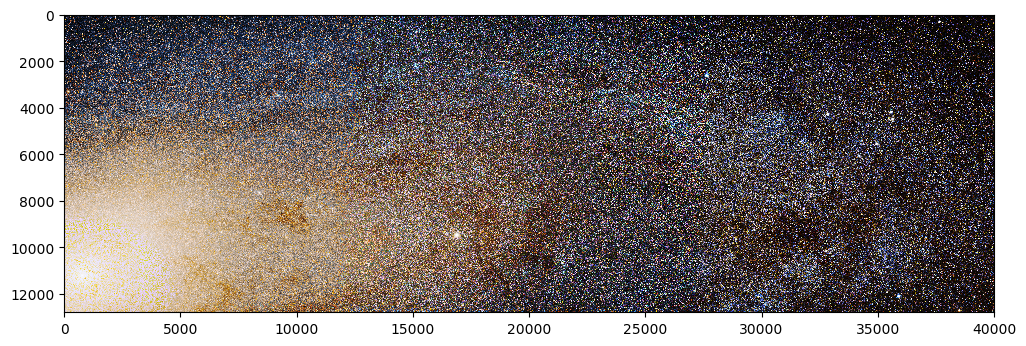

In [9]:
%%time
image = scipy.misc.imread('../data/heic1502a.tif')
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
my_image = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])

print('Image size : %s' %(list(np.shape(image))) )
print('Data size : %s' %(list(np.shape(my_image))) ) #the image is flatten over the third dimension

#store for batch size:
batch_size = max(np.shape(image))

#delete the initial image
del image

### 3.A.a. For a fixed k number and large size image<a name="k fixed"></a>

** 500 Millions of pixels, 6 centroids**

In [10]:
# Some parameters we will keep in a context of big data

n_clusters = 15 #number of clusters
max_iter = 100 #maximal number of iterations
learning_rate = 0.0001 #learning rate in gradient descent
epsilon = 0.001 #iterations will be stopped when the cost functions does not change by 0.01% (early stop)

We favor CPU method because of low K value as seen in the previous notebook (benchmark)

In [11]:
%%time
centroids_big_theano_cpu,t_cpu = kmeans_theano_cpu(my_image,n_clusters, learning_rate, max_iter, batch_size,
                                                   epsilon,verbose=False)

Used the CPU
CPU times: user 22min 51s, sys: 45.9 s, total: 23min 37s
Wall time: 4min 7s


- > One can notice the big difference in time between CPU time and wall time, the explanation is that six cores have been assigned to process the function hence the CPU time 6*2minutes.

** Delta Time between CPU time and Wall time is because of writing files on the disk**

** WARNING reconstruction of image may crash your computer since this is a mixture of memory and disk computation**

CPU times: user 26.2 s, sys: 7.77 s, total: 34 s
Wall time: 33.1 s


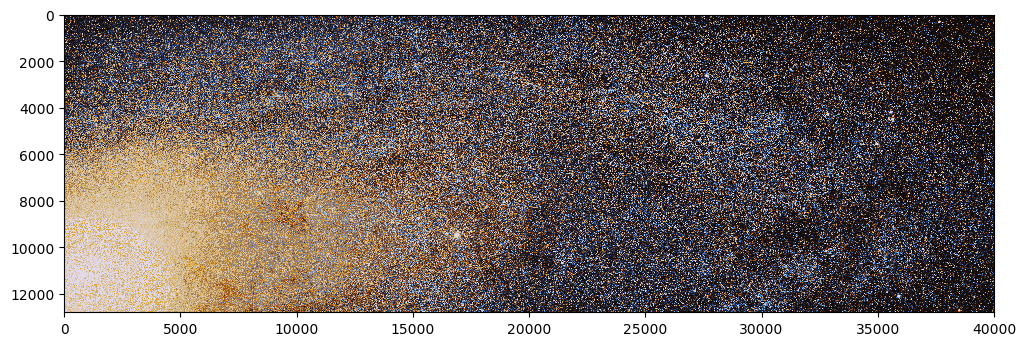

In [12]:
%%time
shape_=np.shape(my_image)[0]
del my_image
fp = np.memmap('temp.dat', dtype=int, mode='r', shape=shape_)
segmented=centroids_big_theano_cpu[fp].astype(np.uint8)
del fp
segmented=np.array(segmented).reshape((w,h, 3))
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(segmented)

In [ ]:
def getLabels(dataSet, centroids,opt=None):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    if opt=='on_disk':
        #print('Array too huge, writting on disk!')
        dist_mat=cydist_(dataSet,centroids)
        filename = 'temp.dat'
        #print('Storing array in %s.' %(filename))
        #load in memory
        fp = np.memmap(filename, dtype='float32', mode='r', shape=(np.shape(dataSet)[0],np.shape(centroids)[0]))
        #dist_mat=sp.distance.cdist(dataSet,centroids,metric="euclidean")
        min_idx=fp.argmin(axis=1) #vector of minimum index for each row
        mat=centroids[min_idx]
        return mat
    else:
        dist_mat=cydist(dataSet,centroids)
        min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
        mat=centroids  

def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols))
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

def cydist_(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    #out = np.zeros((rows,cols))
    filename = 'temp.dat'
    fp = np.memmap(filename, dtype='float32', mode='w+', shape=(rows,cols))
    for dim in range(dims):
        fp[:] += np.subtract.outer(a[:,dim], b[:,dim])**2
    return 

def cydist_2(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    #out = np.zeros((rows,cols))
    filename = 'temp.dat'
    fp = np.memmap(filename, dtype='float32', mode='w+', shape=(rows,cols))
    for dim in range(dims):
        filename_a = 'temp_a.dat'
        filename_b = 'temp_b.dat'
        fp_a = np.memmap(filename_a, dtype='float32', mode='w+', shape=np.shape(a))
        fp_b = np.memmap(filename_b, dtype='float32', mode='w+', shape=np.shape(b))
        fp_a[:,dim]=a[:,dim]
        fp_b[:,dim]=b[:,dim]
        fp[:] += np.subtract.outer(fp_a[:,dim], fp_b[:,dim])**2
        del fp_a
        del fp_b
        print('Done for dim : %s' %(dim))
    return


def getLabelsHuge(dataSet,centroids,chunk=1000000,opt=None):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    mat=np.array([]).reshape(0,np.shape(centroids)[1])
    loop=0
    for i in range(0,np.shape(dataSet)[0],chunk):
        mat=np.concatenate((mat,getLabels(dataSet[i:i+chunk,:],centroids,opt=opt)),axis=0)
        loop+=1
        if (loop % 100) == 0:
            print("Done with loop number : %s" %(loop))
    return mat

# 4 - Conclusion <a name="conclusion"></a>

Reconstructing the quantified picture is the real issue, since we need to attribute to each pixel its colour  centroid, the computation is here a N * K problem which is clearly to avoid since it puts to heavy strends the RAM memory.

In order to bypass memory error issues, we computed vectors by batch (size of chunk depending on available RAM capacity) and once done we stored them on disk before proceding further.